##### Install dependencies

In [7]:
from pathlib import Path
import os, tqdm
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from matplotlib.patches import Wedge, PathPatch
from matplotlib.text import TextPath
print('Imported all packages successfully.')

Imported all packages successfully.


Import modified version of Phonet

In [1]:
from phonet import Phonet
phon = Phonet(["consonantal"])
audio_file = "/home/aleph/phonet/phonet/audios/pataka.wav"
df, phoneme_and_probas = Phonet.get_phon_wav(phon, audio_file=audio_file, plot_flag=False)

2024-04-22 11:55:41.556767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-22 11:55:41.556783: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-22 11:55:42.465093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-22 11:55:42.465346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-22 11:55:42.465409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [2]:
df

,time,phoneme,consonantal
0,0.00,P,0.799695
1,0.01,P,0.875405
2,0.02,P,0.913650
3,0.03,K,0.917522
4,0.04,K,0.864897
...,...,...,...
310,3.10,sp,0.289181
311,3.11,sp,0.329017
312,3.12,sp,0.405769
313,3.13,sp,0.523582


##### Define functions for phoneme extraction

In [3]:
def get_phoneme_class_posterior_means(audio_file,
                                      phon_classes=['vocalic', 'lateral', 'consonantal', 'back']):
  """Get posterior probabilities averaged over each phoneme
  class from an audio file, using Phonet."""
  phon=Phonet(phon_classes)
  df, phoneme_and_probas = Phonet.get_phon_wav(phon, audio_file=audio_file, plot_flag=False)

  # Calculate average over each column
  df2 = df.mean(axis=0, numeric_only=True)
  df3 = pd.DataFrame(df2).transpose()
  df4 = df3[df3.columns[1:]]
  #posterior_means = df4.iloc[0].to_list() # Convert values to list
  posterior_means = df4  
  return df, posterior_means, phoneme_and_probas

In [4]:
def get_phoneme_posterior_means(audio_file,
                                phon_classes=['vocalic', 'lateral', 'consonantal', 'back'],
                                phonemes=['p', 'a', 't', 'k']):
  """Get posterior probabilities for each phoneme
  from an audio file, using Phonet."""
  df, _, _ = get_phoneme_class_posterior_means(audio_file, phon_classes)
  phoneme_means = df.groupby('phoneme').mean(numeric_only=True).drop(columns=['time'])
  query = ""
  for i, phoneme in enumerate(phonemes):
    if i == len(phonemes)-1:
      query += f"phoneme == '{phoneme}'"
    elif len(phonemes) > 1:
      query += f"phoneme == '{phoneme}'|"
    else:
      query = f"phoneme == '{phoneme}"
      break

  # Keep only phonemes of interest
  selected_phoneme_means = phoneme_means.query(f"{query}")
  return df, selected_phoneme_means

##### Extract articulation and phonemic features from databases

In [ ]:
#conditions = ['AD', 'bvFTD', 'CN_1', 'CN_2', 'PD']
conditions = ['CN_1', 'CN_2']
#conditions = ['bvFTD']
#tasks = ['lamina_1', 'lamina_2', 'lectura', 'pataka', 
#         'recuerdo_agradable', 'renarracion', 'rutina_diaria',
#         'vocal_a']
task = 'pataka'

base_dir = Path("E:/fondecyt/FONDECYT_base/")

all_audios = []

for condition in conditions:
    print('-'*20)
    print(f'Now analyzing: {condition}')
    path_to_IDs = Path(base_dir, condition)
    list_of_audios = []
    for path, currentDirectory, files in os.walk(Path(base_dir, condition)):
        #print(path)
        for file in files:
            if 'pataka' in file and 'vad' in file and '16000_channelnorm' not in file and 'diarized' not in file:
                list_of_audios.append(os.path.join(path,file))
                all_audios.append(os.path.join(path,file))
    print(list_of_audios)
    print(f"Number of audios to analyze for {condition}: {len(list_of_audios)}")

print('-'*20)
print(f"Number of audios to analyze in total: {len(all_audios)}")
print('-'*20)

all_posterior_means = []
all_phoneme_means = []
all_phoneme_and_probas = []

for audio in tqdm.tqdm(all_audios):
    audiodata, sr = sf.read(audio)
    #assert(sr == 16000)
    #print(sr)
    df1, posterior_means, phoneme_and_probas = get_phoneme_class_posterior_means(audio)
    df2, phoneme_means = get_phoneme_posterior_means(audio)
    all_posterior_means.append(posterior_means)
    all_phoneme_means.append(phoneme_means)
    all_phoneme_and_probas.append(phoneme_and_probas)


##### Generate phonemic identifiability plot

In [5]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def example_data(scores_dict):
    phonemes = list(scores_dict.keys())
    scores = list(scores_dict.values())
    data = [phonemes, scores]
    #     phonemes,
    #     ('Scores', [
    #         scores])
    #     # ('Phoneme means',
    #     #     values_list
    #     # )
    # ]
    return data

def realign_polar_xticks(ax):
    for theta, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        theta = theta * ax.get_theta_direction() + ax.get_theta_offset()
        theta = np.pi/2 - theta
        y, x = np.cos(theta), np.sin(theta)
        if x >= 0.1:
            label.set_horizontalalignment('left')
        if x <= -0.1:
            label.set_horizontalalignment('right')
        if y >= 0.5:
            label.set_verticalalignment('bottom')
        if y <= -0.5:
            label.set_verticalalignment('top')

def create_outer_circle(ax, center, radius, section_colors, labels):
    #center = (0.5, 0.5)

    # Draw outer circle
    outer_circle = plt.Circle(center, radius, edgecolor='black',
                              facecolor='none', lw=2)
    ax.add_patch(outer_circle)

    # Draw sections and labels
    num_sections = len(section_colors)
    theta_start = 0
    theta_end = 360 / num_sections

    for color, label in zip(section_colors, labels):
        # Highlighted section
        section = Wedge(center, radius, theta_start, theta_end, 
                        facecolor=color, edgecolor='none')
        ax.add_patch(section)

        # Add curved label along the section
        text_path = TextPath((0,0), label, size=12)
        trans = Affine2D().rotate_deg((theta_start + theta_end) / 2).translate(center[0], center[1])
        path_patch = PathPatch(text_path, facecolor='none', edgecolor='none', transform=trans)
        ax.add_patch(path_patch)

        theta_start += 360 / num_sections
        theta_end += 360 / num_sections

#if __name__ == '__main__':
def create_radar_plot(scores_dict, audio_file):
    N = len(list(scores_dict.keys()))
    theta = radar_factory(N, frame='polygon')

    data = example_data(scores_dict)
    spoke_labels = data.pop(0)
    #spoke_labels = ['Target\nvowels', 'Non-target\nvowels', 'Target\nplosives', 'Non-target\nplosives', 'Other\nphonemes']

    fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))
    #fig.subplots_adjust(wspace=0.55, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']

    #ax.set_title("Phonemic identifiability", weight='bold', size='medium', position=(0.5, 1.1),
    #                horizontalalignment='center', pad=20)
    # for d, color in zip(data, colors):
    ax.plot(theta, data[0], color='b')
    #grid_max = np.ceil(max(data[0])*10)/10
    grid_max = 1.0
    ngrids = 10
    rgrids = np.linspace(0.1, grid_max, ngrids)
    
    #ax.set_rgrids(rgrids, labels=["0.1","","0.3","","0.5","","0.7","","0.9","1.0"])
    ax.text(0.5, 0.02, '0')
    ax.text(0.5, 0.11, '0.1')
    ax.text(0.5, 0.195, '0.2')
    ax.text(0.5, 0.275, '0.3')
    ax.text(0.5, 0.357, '0.4')
    ax.text(0.5, 0.44, '0.5')
    ax.text(0.5, 0.525, '0.6')
    ax.text(0.5, 0.605, '0.7')
    ax.text(0.5, 0.688, '0.8')
    ax.text(0.5, 0.765, '0.9')
    ax.text(0.5, 0.835, '1')

    ax.fill(theta, data[0], facecolor='b', alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    realign_polar_xticks(ax)
    ax.set_rmax(grid_max)
    
    # Adjust the radial grid lines
    ax.set_yticks(np.linspace(0.1, grid_max, ngrids))  # Customize the number of grid lines as needed
    ax.set_yticklabels([])
    
    # # Set the radial limits with some padding
    # ax.set_rlim(0, grid_max + 0.1)  # You can adjust the padding as needed

    # Set the aspect ratio to be equal
    ax.set_aspect('equal')

    # # Customize grid lines
    # ax.grid(color='gray', linestyle='-', linewidth=1)  # Customize color, linestyle, and linewidth as needed

    # # Hide the last radial grid line
    # ax.spines['polar'].set_visible(False)


    # Parameters for the outer circle and sections
    # outer_circle_radius = 1.2
    # section_colors = ['cyan', 'magenta', 'yellow', 'green']

    # Create and display the outer circle with labeled sections
    #create_outer_circle(ax, (0.5, 0.5), outer_circle_radius, section_colors, section_labels)
    

    plt.tight_layout()
    #plt.savefig(f"{audio_file}.png")
    plt.show()

def create_radar_plot_2_conditions(scores_dict, scores_dict_2, label_1, label_2, output_image):
    N = len(list(scores_dict.keys()))
    theta = radar_factory(N, frame='polygon')

    data = example_data(scores_dict)
    data_2 = example_data(scores_dict_2)

    spoke_labels = data.pop(0)
    spoke_labels = data_2.pop(0)
    #spoke_labels = ['Target\nvowels', 'Non-target\nvowels', 'Target\nplosives', 'Non-target\nplosives', 'Other\nphonemes']

    fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))
    #fig.subplots_adjust(wspace=0.55, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']

    #ax.set_title("Phonemic identifiability", weight='bold', size='medium', position=(0.5, 1.1),
    #                horizontalalignment='center', pad=20)
    # for d, color in zip(data, colors):
    ax.plot(theta, data[0], color='b', label=label_1)
    ax.plot(theta, data_2[0], color='g', label=label_2)
    #grid_max = np.ceil(max(data[0])*10)/10
    grid_max = 1.0
    ngrids = 10
    rgrids = np.linspace(0.1, grid_max, ngrids)
    
    #ax.set_rgrids(rgrids, labels=["0.1","","0.3","","0.5","","0.7","","0.9","1.0"])
    ax.text(0.5, 0.02, '0')
    ax.text(0.5, 0.11, '0.1')
    ax.text(0.5, 0.195, '0.2')
    ax.text(0.5, 0.275, '0.3')
    ax.text(0.5, 0.357, '0.4')
    ax.text(0.5, 0.44, '0.5')
    ax.text(0.5, 0.525, '0.6')
    ax.text(0.5, 0.605, '0.7')
    ax.text(0.5, 0.688, '0.8')
    ax.text(0.5, 0.765, '0.9')
    ax.text(0.5, 0.835, '1')

    ax.fill(theta, data[0], facecolor='b', alpha=0.15)
    ax.fill(theta, data_2[0], facecolor='g', alpha=0.15)
    ax.legend()
    ax.set_varlabels(spoke_labels)

    realign_polar_xticks(ax)
    ax.set_rmax(grid_max)
    
    # Adjust the radial grid lines
    ax.set_yticks(np.linspace(0.1, grid_max, ngrids))  # Customize the number of grid lines as needed
    ax.set_yticklabels([])
    
    # # Set the radial limits with some padding
    # ax.set_rlim(0, grid_max + 0.1)  # You can adjust the padding as needed

    # Set the aspect ratio to be equal
    ax.set_aspect('equal')

    # # Customize grid lines
    # ax.grid(color='gray', linestyle='-', linewidth=1)  # Customize color, linestyle, and linewidth as needed

    # # Hide the last radial grid line
    # ax.spines['polar'].set_visible(False)


    # Parameters for the outer circle and sections
    # outer_circle_radius = 1.2
    # section_colors = ['cyan', 'magenta', 'yellow', 'green']

    # Create and display the outer circle with labeled sections
    #create_outer_circle(ax, (0.5, 0.5), outer_circle_radius, section_colors, section_labels)
    

    plt.tight_layout()
    plt.savefig(output_image)
    plt.show()

Identify phonemes in audio and generate plot

In [8]:
audio_file = r"/home/aleph/phonet/phonet/audios/pataka.wav"
_, _, phoneme_and_probas = get_phoneme_class_posterior_means(audio_file)
phoneme_and_probas

[('P', 0.33385164),
 ('P', 0.44591603),
 ('P', 0.43212208),
 ('K', 0.44371957),
 ('K', 0.39824703),
 ('K', 0.34989724),
 ('AA', 0.4347499),
 ('AA', 0.5252204),
 ('AA', 0.5281555),
 ('AA', 0.44446188),
 ('AE', 0.52092993),
 ('AE', 0.5429624),
 ('AE', 0.55958474),
 ('AE', 0.60302454),
 ('AE', 0.61392653),
 ('AE', 0.59127176),
 ('AE', 0.5578945),
 ('AE', 0.5404239),
 ('AE', 0.54794264),
 ('AE', 0.460425),
 ('AE', 0.360279),
 ('T', 0.25420028),
 ('T', 0.38556454),
 ('T', 0.44679675),
 ('T', 0.4799184),
 ('T', 0.47062135),
 ('T', 0.45041838),
 ('T', 0.3765793),
 ('T', 0.28807923),
 ('AY', 0.31324196),
 ('AY', 0.3735735),
 ('AY', 0.40413225),
 ('AY', 0.4295351),
 ('AY', 0.4312818),
 ('AY', 0.43618202),
 ('AY', 0.46328777),
 ('AY', 0.5204035),
 ('AY', 0.57121044),
 ('AY', 0.52629673),
 ('AY', 0.3894587),
 ('AE', 0.23956576),
 ('AE', 0.17347169),
 ('K', 0.44904438),
 ('K', 0.7211452),
 ('K', 0.8953363),
 ('K', 0.95893437),
 ('K', 0.9617639),
 ('K', 0.94471806),
 ('K', 0.9091705),
 ('K', 0.8643

In [9]:
def without_keys(d, keys):
    return {x: d[x] for x in d if x not in keys}

def phonemic_identifiability_plot(audio_file):
    """Generate a phonemic identifiability radar plot for an audio
    of a participant performing the 'pataka' task.

    Phoneme predictions are done using Phonet.
    
    The results are analyzed for 4 different custom classes that are relevant to this task:
    - Target sounds: 'p', 't', 'k', 'a'
    - Voicing alterations: 'b', 'd', 'g'
    - Vowel alterations: 'e', i', 'o', 'u', 'w'
    - Non-target consonants: (all other phonemes)
    """

    print('-' *5+ 'Now analyzing' + '-'*5)
    print(f'Audio: {audio_file}')

    vocalic = ["a","e","i","o","u","w"]
    consonant = ["j","b","B","d","D","f","F","k","l","m","n","N","p","r","rr","s","Z","T","t","g","G","tS","S","x", "jj", "J", "L", "z"]

    all_phonemes = vocalic + consonant
    phoneme_dict = dict([(key,[]) for key in all_phonemes])

    # Set counters for number of times vocalic or consonant phonemes are identified.
    vocalic_counter = 0
    consonant_counter = 0
    vocalic_sum = 0
    consonant_sum = 0

    # Get phonemes and their prediction confidence using phonet
    _, _, phoneme_and_probas = get_phoneme_class_posterior_means(audio_file)
    print(phoneme_and_probas)

    #Create counters for the number of times that vocalic and consonants were enunciated
    for phoneme_tuple in phoneme_and_probas:
        if phoneme_tuple[0] in all_phonemes:
            phoneme_dict[phoneme_tuple[0]].append(phoneme_tuple[1])
        if phoneme_tuple[0] in vocalic:
            vocalic_counter+=1
            vocalic_sum += phoneme_tuple[1]
        elif phoneme_tuple[0] in consonant:
            consonant_counter+=1
            consonant_sum += phoneme_tuple[1]
    

    # phoneme_prob_sum = dict([(key,[]) for key in all_phonemes])
    # for key in phoneme_dict:
    #     phoneme_prob_sum[key] = sum(phoneme_dict[key])

    print('-'*5+f' N of consonants identified: {consonant_counter} '+'-'*5)
    print('-'*5+f' N of vocalics identified: {vocalic_counter} '+'-'*5)
    print('-'*5+f' Sum of consonants and vocalics: {consonant_counter+vocalic_counter} '+'-'*5)



    exclude = {"a", "e", "i", "o", "u", "w", "p", "t", "T", "k", "b", "B", "d", "D", "g", "G", "sil", "<p:>"}
    non_target_phonemes = without_keys(phoneme_dict, exclude)
    
    print('-'*5+' Target sounds '+'-'*5)
    #p_score = sum(phoneme_dict['p']) / consonant_counter
    p_score = sum(phoneme_dict['p']) / consonant_sum
    #p_score = len(phoneme_dict['p']) / consonant_counter
    print('/p/:', p_score)

    #t_score = ( sum(phoneme_dict['t']) + sum(phoneme_dict['T']) ) / consonant_counter
    t_score = ( sum(phoneme_dict['t']) + sum(phoneme_dict['T']) ) / consonant_sum
    #t_score = ( len(phoneme_dict['t']) + len(phoneme_dict['T']) ) / consonant_counter
    print('/t/:', t_score)

    #k_score = sum(phoneme_dict['k']) / consonant_counter
    k_score = sum(phoneme_dict['k']) / consonant_sum
    #k_score = len(phoneme_dict['k']) / consonant_counter
    print('/k/:', k_score)

    #print(phoneme_dict['a'])
    #a_score = sum(phoneme_dict['a']) / vocalic_counter
    a_score = sum(phoneme_dict['a']) / vocalic_sum
    #a_score = len(phoneme_dict['a']) / vocalic_counter
    print('/a/:', a_score)

    print('-'*5+' Vowel alterations '+'-'*5)
    #e_score = sum(phoneme_dict['e']) / vocalic_counter
    e_score = sum(phoneme_dict['e']) / vocalic_sum
    #e_score = len(phoneme_dict['e']) / vocalic_counter
    print('/e/:', e_score)

    #i_score = sum(phoneme_dict['i']) / vocalic_counter
    i_score = sum(phoneme_dict['i']) / vocalic_sum
    #i_score = len(phoneme_dict['i']) / vocalic_counter
    print('/i/:', i_score)

    #o_score = sum(phoneme_dict['o']) / vocalic_counter
    o_score = sum(phoneme_dict['o']) / vocalic_sum
    #o_score = len(phoneme_dict['o']) / vocalic_counter
    print('/o/:', o_score)

    #u_score = sum(phoneme_dict['u']) / vocalic_counter
    u_score = sum(phoneme_dict['u']) / vocalic_sum
    #u_score = len(phoneme_dict['u']) / vocalic_counter
    print('/u/:', u_score)

    #w_score = sum(phoneme_dict['w']) / vocalic_counter
    w_score = sum(phoneme_dict['w']) / vocalic_sum
    #w_score = len(phoneme_dict['w']) / vocalic_counter
    print('/w/:', w_score)

    print('-'*5+' Voicing alterations '+'-'*5)
    #b_score = ( sum(phoneme_dict['b']) + sum(phoneme_dict['B']) ) / consonant_counter
    b_score = ( sum(phoneme_dict['b']) + sum(phoneme_dict['B']) ) / consonant_sum
    #b_score = ( len(phoneme_dict['b']) + len(phoneme_dict['B']) ) / consonant_counter
    print('/b/', b_score)

    #d_score = ( sum(phoneme_dict['d']) + sum(phoneme_dict['D']) ) / consonant_counter
    d_score = ( sum(phoneme_dict['d']) + sum(phoneme_dict['D']) ) / consonant_sum
    #d_score = ( len(phoneme_dict['d']) + len(phoneme_dict['D']) ) / consonant_counter
    print('/d/', d_score)

    #g_score = ( sum(phoneme_dict['g']) + sum(phoneme_dict['G']) ) / consonant_counter
    g_score = ( sum(phoneme_dict['g']) + sum(phoneme_dict['G']) ) / consonant_sum
    #g_score = ( len(phoneme_dict['g']) + len(phoneme_dict['G']) ) / consonant_counter
    print('/g/', g_score)

    print('-'*5+' Non-target consonants '+'-'*5)

    non_target_sum = 0
    non_target_list = []
    for key in non_target_phonemes.keys():
        non_target_sum += sum(non_target_phonemes[key])
        non_target_list.extend(non_target_phonemes[key])

    #non_target_score = non_target_sum / consonant_counter
    non_target_score = non_target_sum / consonant_sum  
    #non_target_score = len(non_target_list) / consonant_counter

    print(non_target_list)
    print('others:', non_target_score)


    scores_dict = {'/b/': b_score,
                    '/d/': d_score,
                    '/g/': g_score,
                    '/p/': p_score,
                    '/t/': t_score,
                    '/k/': k_score,
                    '/a/': a_score,
                    '/e/': e_score,
                    '/i/': i_score,
                    '/o/': o_score,
                    '/u/': u_score,
                    '/w/': w_score,
                    'others': non_target_score
                }

    #sum_total = 0
    #for key in scores_dict.keys():
    #    sum_total += scores_dict[key]

    sum_vocalic = a_score + e_score + i_score + o_score + u_score + w_score
    sum_consonant = b_score + d_score + g_score + p_score + t_score + k_score + non_target_score

    print('-'*5+f'Sum of all vocalic probabilities: {sum_vocalic}'+'-'*5)
    print('-'*5+f'Sum of all consonant probabilities: {sum_consonant}'+'-'*5)

    audio_file_stem = os.path.splitext(audio_file)[0]
    create_radar_plot(scores_dict, audio_file_stem)
    scores_df = pd.DataFrame(scores_dict, index=[0])
    scores_df.to_csv(f"{audio_file_stem}_PhonIdent_scores.csv")

    

In [10]:
def phonemic_identifiability_plot_5classes(audio_file):
    """Generate a phonemic identifiability radar plot for an audio
    of a participant performing the 'pataka' task.

    Phoneme predictions are done using Phonet.
    
    The results are analyzed for 5 different custom classes that are relevant to this task:
    - Target plosives: p, t, k
    - Non-target plosives: b, d, g
    - Target vowel: a
    - Non-target vowels: e, i, o, u
    - Other phonemes
    """

    print('-' *5+ 'Now analyzing' + '-'*5)
    print(f'Audio: {audio_file}')

    vocalic = ["a","e","i","o","u","w"]
    consonant = ["j","b","B","d","D","f","F","k","l","m","n","N","p","r","rr","s","Z","T","t","g","G","tS","S","x", "jj", "J", "L", "z"]
    all_phonemes = vocalic + consonant

    target_plosives = ["p", "P", "t", "T", "k", "K"]
    target_vowels = ["a"]
    non_target_plosives = ["b", "B", "d", "D", "g", "G"]
    non_target_vowels = ["e", "i", "o", "u"]
    other_consonants = []

    for x in all_phonemes:
        if x not in non_target_plosives + target_plosives + non_target_vowels + target_vowels:
            other_consonants.append(x)
    
    phoneme_dict = dict([(key,[]) for key in all_phonemes])

    # Set counters for number of times vocalic or consonant phonemes are identified.
    target_plosives_counter = 0 
    target_plosives_sum = 0
    target_vowels_counter = 0
    target_vowels_sum = 0 
    non_target_plosives_counter = 0
    non_target_plosives_sum = 0
    non_target_vowels_counter = 0
    non_target_vowels_sum = 0
    other_consonants_counter = 0
    other_consonants_sum = 0

    # Get phonemes and their prediction confidence using phonet
    _, _, phoneme_and_probas = get_phoneme_class_posterior_means(audio_file)
    print(phoneme_and_probas)

    #Create counters for the number of times that vocalic and consonants were enunciated
    for phoneme_tuple in phoneme_and_probas:
        if phoneme_tuple[0] in all_phonemes:
            phoneme_dict[phoneme_tuple[0]].append(phoneme_tuple[1])
        if phoneme_tuple[0] in target_plosives:
            target_plosives_counter+=1
            target_plosives_sum += phoneme_tuple[1]
        elif phoneme_tuple[0] in non_target_plosives:
            non_target_plosives_counter+=1
            non_target_plosives_sum += phoneme_tuple[1]
        elif phoneme_tuple[0] in target_vowels:
            target_vowels_counter += 1
            target_vowels_sum += phoneme_tuple[1]
        elif phoneme_tuple[0] in non_target_vowels:
            non_target_vowels_counter += 1
            non_target_vowels_sum += phoneme_tuple[1]
        elif phoneme_tuple[0] in other_consonants:
            other_consonants_counter += 1
            other_consonants_sum += phoneme_tuple[1]

    #exclude = {"a", "e", "i", "o", "u", "p", "t", "T", "k", "b", "B", "d", "D", "g", "G", "sil", "<p:>"}
    #non_target_phonemes = without_keys(phoneme_dict, exclude)

    print('-'*5+f'N of target plosives: {target_plosives_counter} '+'-'*5)
    print('-'*5+f'N of non-target plosives: {non_target_plosives_counter} '+'-'*5)
    print('-'*5+f'N of target vowels: {target_vowels_counter} '+'-'*5)
    print('-'*5+f'N of non-target vowels: {non_target_vowels_counter}'+'-'*5)
    print('-'*5+f'N of other consonants: {other_consonants_counter}'+'-'*5)

    print('-'*5+' Target plosives (p, t, k) '+'-'*5)
    if (target_plosives_sum + non_target_plosives_sum + other_consonants_sum) != 0:
        target_plosives_score = target_plosives_sum / (target_plosives_sum + non_target_plosives_sum + other_consonants_sum)
    else:
        target_plosives_score = 0
    #target_plosives_score = target_plosives_counter / (target_plosives_counter + non_target_plosives_counter + other_consonants_counter)
    print('Target plosives: ', target_plosives_score)

    print('-'*5+' Non-target plosives (b, d, g) '+'-'*5)
    if (target_plosives_sum + non_target_plosives_sum + other_consonants_sum) != 0:
        non_target_plosives_score = non_target_plosives_sum / (target_plosives_sum + non_target_plosives_sum + other_consonants_sum)
    else:
        non_target_plosives_score = 0
    #non_target_plosives_score = non_target_plosives_counter / (target_plosives_counter + non_target_plosives_counter + other_consonants_counter)
    print('Non-target plosives: ', non_target_plosives_score)

    print('-'*5+' Target vowels (a) '+'-'*5)
    if (target_vowels_sum + non_target_vowels_sum) != 0:
        target_vowels_score = target_vowels_sum / (target_vowels_sum + non_target_vowels_sum)
    else:
        target_vowels_score = 0
    #target_vowels_score = target_vowels_counter / (target_vowels_counter + non_target_vowels_counter)
    print('Target vowels: ', target_vowels_score)

    print('-'*5+' Non-target vowels (e, i, o , u) '+'-'*5)
    if (target_vowels_sum + non_target_vowels_sum) != 0:
        non_target_vowels_score = non_target_vowels_sum / (target_vowels_sum + non_target_vowels_sum)
    else:
        non_target_vowels_score = 0
    #non_target_vowels_score = non_target_vowels_counter / (target_vowels_counter + non_target_vowels_counter)
    print('Non-target vowels: ', non_target_vowels_score)

    print('-'*5+' Other consonants '+'-'*5)
    if (target_vowels_sum + non_target_vowels_sum + target_plosives_sum + non_target_plosives_sum) != 0:
        other_consonants_score = other_consonants_sum / (target_vowels_sum + non_target_vowels_sum + target_plosives_sum + non_target_plosives_sum)
    else:
        other_consonants_score = 0
    #other_consonants_score = other_consonants_counter / (target_vowels_counter + non_target_vowels_counter + target_plosives_counter + non_target_plosives_counter)
    print('Other consonants: ', other_consonants_score)

    scores_dict = {'Target vowels': target_vowels_score,
                   'Non-target vowels': non_target_vowels_score,
                   'Target plosives': target_plosives_score,
                   'Non-target plosives': non_target_plosives_score,
                   'Other phonemes': other_consonants_score
                   }

    #sum_vocalic = a_score + e_score + i_score + o_score + u_score + w_score
    #sum_consonant = b_score + d_score + g_score + p_score + t_score + k_score + non_target_score

    #print('-'*5+f'Sum of all vocalic probabilities: {sum_vocalic}'+'-'*5)
    #print('-'*5+f'Sum of all consonant probabilities: {sum_consonant}'+'-'*5)

    audio_file_stem = os.path.splitext(audio_file)[0]
    create_radar_plot(scores_dict, audio_file_stem)
    scores_df = pd.DataFrame(scores_dict, index=[0])
    scores_df.to_csv(f"{audio_file_stem}_PhonIdent_scores.csv")

Test

-----Now analyzing-----
Audio: /home/aleph/phonet/phonet/audios/sentence.wav


/home/aleph/phonet/phonet/phonet.py:229: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal=read(audio_file)
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


[('sp', 0.36913753), ('sp', 0.47645319), ('sp', 0.6087397), ('sp', 0.68032676), ('sp', 0.60380226), ('sp', 0.5203398), ('sp', 0.4721721), ('sp', 0.44740275), ('sp', 0.35878256), ('sp', 0.25794795), ('W', 0.1861933), ('W', 0.288766), ('W', 0.2624472), ('IH', 0.21042302), ('IH', 0.34625718), ('IH', 0.39296225), ('AH', 0.4425003), ('AH', 0.5293365), ('AH', 0.6173122), ('AH', 0.59763557), ('AH', 0.51955), ('AH', 0.35716543), ('Z', 0.5637267), ('Z', 0.810204), ('Z', 0.83172435), ('Z', 0.79756737), ('Z', 0.65993506), ('Z', 0.5254145), ('Z', 0.41836682), ('Z', 0.2874647), ('Z', 0.15208082), ('AA', 0.17359728), ('AA', 0.3258592), ('AA', 0.39740837), ('AA', 0.47806507), ('AA', 0.5050131), ('AA', 0.50720745), ('AA', 0.517794), ('AA', 0.4654583), ('AA', 0.3756309), ('S', 0.115983605), ('S', 0.2483367), ('S', 0.47324637), ('S', 0.5147659), ('S', 0.4034782), ('S', 0.41424736), ('S', 0.47820488), ('S', 0.5097047), ('S', 0.5227034), ('S', 0.5350506), ('S', 0.5596022), ('S', 0.58498424), ('S', 0.59684

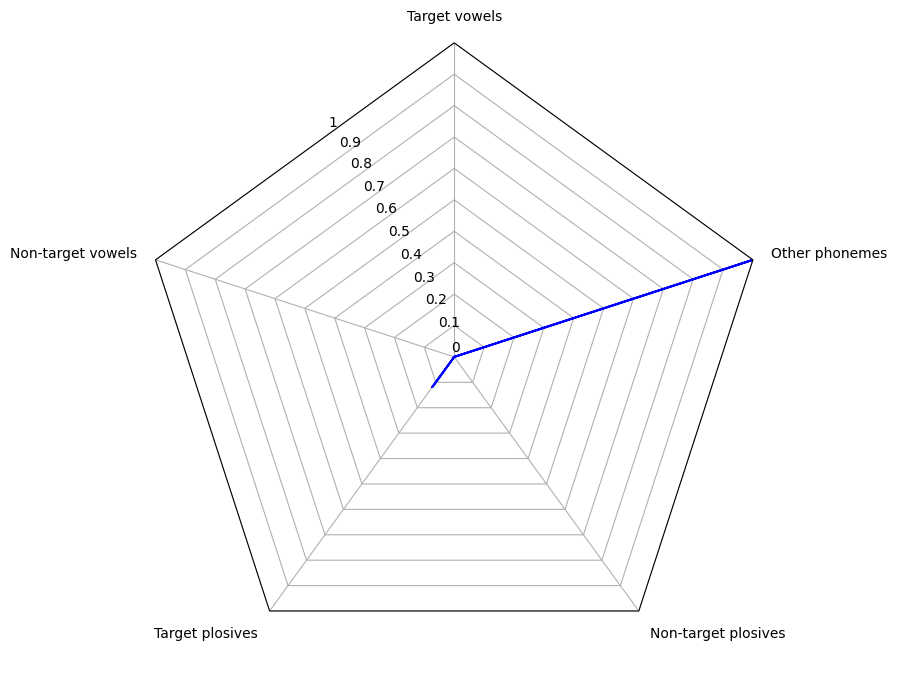

Finished sentence.wav
-----Now analyzing-----
Audio: /home/aleph/phonet/phonet/audios/pataka.wav
[('P', 0.33385164), ('P', 0.44591603), ('P', 0.43212208), ('K', 0.44371957), ('K', 0.39824703), ('K', 0.34989724), ('AA', 0.4347499), ('AA', 0.5252204), ('AA', 0.5281555), ('AA', 0.44446188), ('AE', 0.52092993), ('AE', 0.5429624), ('AE', 0.55958474), ('AE', 0.60302454), ('AE', 0.61392653), ('AE', 0.59127176), ('AE', 0.5578945), ('AE', 0.5404239), ('AE', 0.54794264), ('AE', 0.460425), ('AE', 0.360279), ('T', 0.25420028), ('T', 0.38556454), ('T', 0.44679675), ('T', 0.4799184), ('T', 0.47062135), ('T', 0.45041838), ('T', 0.3765793), ('T', 0.28807923), ('AY', 0.31324196), ('AY', 0.3735735), ('AY', 0.40413225), ('AY', 0.4295351), ('AY', 0.4312818), ('AY', 0.43618202), ('AY', 0.46328777), ('AY', 0.5204035), ('AY', 0.57121044), ('AY', 0.52629673), ('AY', 0.3894587), ('AE', 0.23956576), ('AE', 0.17347169), ('K', 0.44904438), ('K', 0.7211452), ('K', 0.8953363), ('K', 0.95893437), ('K', 0.9617639), (

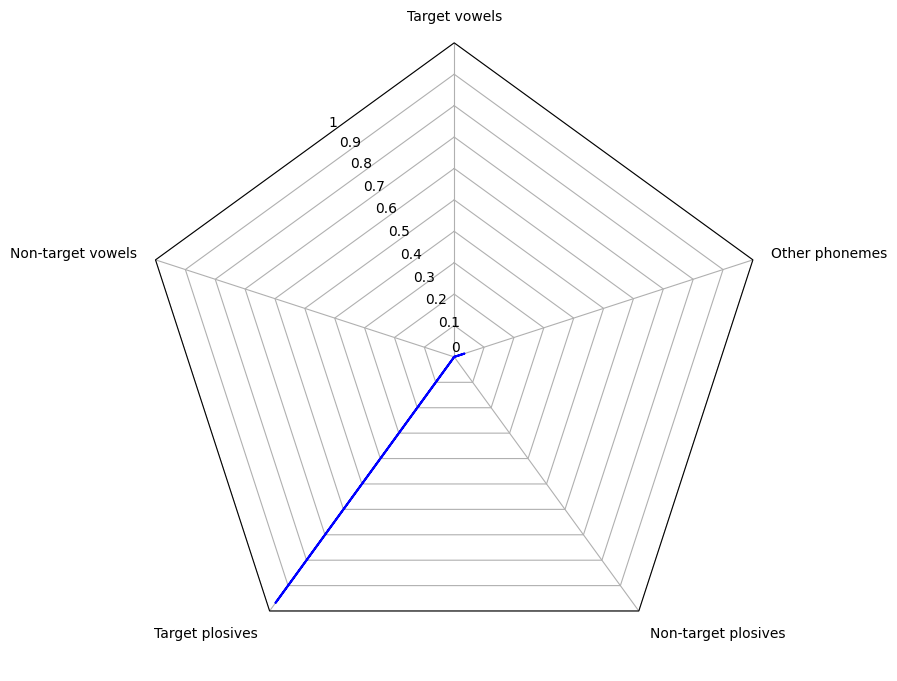

Finished pataka.wav


In [12]:
# Extract plot and save dictionary for AD
for root, dirs, files in os.walk("/home/aleph/phonet/phonet/audios"):
    for file in files:
        if file.endswith('.wav'):
                #print(os.path.join(root, file))
                # Call phonemic identifiability function
                phonemic_identifiability_plot_5classes(os.path.join(root,file))
                print(f"Finished {file}")

In [ ]:
# Extract plot and save dictionary for bvFTD
for root, dirs, files in os.walk("E:/fondecyt/FONDECYT_base/bvFTD"):
    for file in files:
        if file.endswith('ataka_mono_16kHz.wav'):
                #print(os.path.join(root, file))
                # Call phonemic identifiability function
                phonemic_identifiability_plot(os.path.join(root,file))
                print(f"Finished {file}")

In [ ]:
# Extract plot and save dictionary for PD
for root, dirs, files in os.walk("E:/fondecyt/FONDECYT_base/PD"):
    for file in files:
        if file.endswith('_Pataka_mono_16kHz.wav'):
                #print(os.path.join(root, file))
                # Call phonemic identifiability function
                phonemic_identifiability_plot(os.path.join(root,file))
                print(f"Finished {file}")

In [ ]:
# Extract plot and save dictionary
condition = "PD"
file_counter = 0
for root, dirs, files in os.walk(f"E:/fondecyt/FONDECYT_base/{condition}"):
    for file in files:
        if file.endswith('ataka_mono_16kHz.wav'):
                #print(os.path.join(root, file))
                # Call phonemic identifiability function
                try:
                    phonemic_identifiability_plot_5classes(os.path.join(root,file))
                    print(f"Finished {file}")
                    file_counter += 1
                except:
                    print(f"{file} couldn't be processed.")

print(f'Total files analyzed: {file_counter}')

In [ ]:
condition = 'PD'
df = pd.DataFrame(columns=[""])
file_counter = 0
for root, dirs, files in os.walk(f"E:/fondecyt/FONDECYT_base/{condition}"):
    for file in files:
        if os.path.join(root,file).endswith("ataka_mono_16kHz_PhonIdent_scores.csv"):
            #print(file)
            df2 = pd.read_csv(os.path.join(root, file))
            #print(df2)
            df = pd.concat([df,df2], axis=0)
            file_counter += 1

avg_scores = df.mean(axis=0).to_dict()
print(avg_scores)
del avg_scores [""]
del avg_scores ['Unnamed: 0']
avg_scores
print(f'Total files analyzed: {file_counter}')
create_radar_plot(avg_scores, f'{condition}_avg_scores_nopreproc_pondcount')

In [ ]:
conditions = ["CN", "PD"]

avg_scores_per_condition = dict()
min_scores_per_condition = dict()
max_scores_per_condition = dict()

for condition in conditions:
    file_counter = 0
    df = pd.DataFrame(columns=[""])
    for root, dirs, files in os.walk(f"E:/fondecyt/FONDECYT_base/{condition}"):
        for file in files:
            if os.path.join(root,file).endswith("ataka_mono_16kHz_PhonIdent_scores.csv"):
                print(file)
                df2 = pd.read_csv(os.path.join(root, file))
                #print(df2)
                df = pd.concat([df,df2], axis=0)
                file_counter += 1

    avg_scores = df.mean(axis=0).to_dict()
    min_scores = df.min(axis=0).to_dict()
    max_scores = df.max(axis=0).to_dict()

    print(avg_scores)
    del avg_scores [""]
    del avg_scores ['Unnamed: 0']
    del min_scores [""]
    del min_scores ['Unnamed: 0']
    del max_scores [""]
    del max_scores ['Unnamed: 0']
    
    #avg_scores
    print(f'Total files analyzed: {file_counter}')
    avg_scores_per_condition[condition] = avg_scores
    min_scores_per_condition[condition] = min_scores
    max_scores_per_condition[condition] = max_scores


create_radar_plot_2_conditions(avg_scores_per_condition[conditions[0]],
                               avg_scores_per_condition[conditions[1]],
                               conditions[0],
                               conditions[1],
                               f"FONDECYT_{conditions[0]}_vs_{conditions[1]}_pondsum_nopreproc.png")

In [ ]:
max_scores_per_condition

In [ ]:
min_scores_per_condition

In [ ]:
min_targetplosives_pd = min_scores_per_condition['PD']['Target plosives']
min_targetplosives_cn = min_scores_per_condition['CN']['Target plosives']
min_targetvowels_pd = min_scores_per_condition['PD']['Target vowels']
min_targetvowels_cn = min_scores_per_condition['CN']['Target vowels']
max_targetplosives_pd = max_scores_per_condition['PD']['Target plosives']
max_targetplosives_cn = max_scores_per_condition['CN']['Target plosives']
max_targetvowels_pd = max_scores_per_condition['PD']['Target vowels']
max_targetvowels_cn = max_scores_per_condition['CN']['Target vowels']

# Define the minimum and maximum values for each bar
min_values = [min_targetplosives_pd, min_targetplosives_cn, min_targetvowels_pd, min_targetvowels_cn]
max_values = [max_targetplosives_pd, max_targetplosives_cn, max_targetvowels_pd, max_targetvowels_cn]

# Define the labels for each bar
labels = ['PD Target Plosives', 'HC Target Plosives', 'PD Target Vowels' ,'HC Target Vowels']

# Set the x-axis limits
plt.xlim(0.0, 1.0)

# Create the horizontal bar graph
bars = plt.barh(labels, max_values, left=min_values)

# Add labels to the bars
for i, (min_val, max_val) in enumerate(zip(min_values, max_values)):
    plt.text((min_val + max_val) / 2, i, f'{min_val:.2f}-{max_val:.2f}', ha='center', va='center')

# Color
bars[3].set_color('#447799')
bars[2].set_color('#5aad5c')
bars[1].set_color('#447799')
bars[0].set_color('#5aad5c')

# Add a title and labels to the axes
plt.title('Phonemic identifiability')
plt.xlabel('Accuracy')
plt.ylabel('Group')

# Display the graph
plt.tight_layout()
plt.savefig('FONDECYT_CN_vs_PD_min_max_scores.png')
plt.show()



In [ ]:
# bvFTD
#audio = "E:/fondecyt/FONDECYT_base/bvFTD/SL00337/Habla/16000_channelnorm/loudnorm/denoised/vad/SL00337_pataka_16000_channelnorm_loudnorm_denoised_vad.wav"
#audio = "E:/fondecyt/FONDECYT_base/bvFTD/SL00337/Habla/mono_16khz/SL00337_pataka_mono_16khz.wav"
#audio = "E:/fondecyt/FONDECYT_base/CN/CN_1/CS0044/Registro_habla/CS0044_vocal_a.wav"
#audio = "E:/fondecyt/FONDECYT_base/bvFTD/SL00337/Habla/SL00337_vocal_a.wav"
#audio = "E:/fondecyt/FONDECYT_base/bvFTD/SL00337/Habla/mono_16khz/SL00337_lamina_1_mono_16kHz.wav"

# CN
#audio = "E:/fondecyt/FONDECYT_base/CN_1/CS0041/Registro_habla/16000_channelnorm/loudnorm/denoised/vad/CS0041_pataka_16000_channelnorm_loudnorm_denoised_vad.wav"
#audio = "E:/fondecyt/FONDECYT_base/CN_1/CS0041/Registro_habla/mono_16khz/loudnorm/denoised/vad/diarized/CS0041_pataka_mono_16kHz_loudnorm_denoised_vad_diarized.wav"
#audio = "E:/fondecyt/FONDECYT_base/CN/CN_1/CS0042/Registro_habla/mono_16khz/CS0042_pataka_mono_16kHz.wav"
#audio = "E:/fondecyt/FONDECYT_base/CN_1/CS0042/Registro_habla/mono_16khz/CS0042_pataka_mono_16kHz.wav"
#audio = "E:/fondecyt/FONDECYT_base/CN_1/CS0044/Registro_habla/mono_16khz/CS0044_pataka_mono_16kHz.wav"
#audio = "E:/fondecyt/FONDECYT_base/CN/CN_1/SL00343/Habla/mono_16khz/SL00343_pataka_mono_16kHz.wav"
#audio = "E:/fondecyt/FONDECYT_base/CN_1/CS0041/Registro_habla/mono_16khz/loudnorm/denoised/CS0041_pataka_mono_16kHz_loudnorm_denoised.wav"
#audio = "E:/fondecyt/FONDECYT_base/CN_1/SL00403/Registro_de_habla/16000_channelnorm/loudnorm/denoised/vad/SL00403_pataka_16000_channelnorm_loudnorm_denoised_vad.wav"
#audio = "E:/fondecyt/FONDECYT_base/CN_1/SL00283/habla/16000_channelnorm/loudnorm/denoised/vad/8_SL00283_Pataka_16000_channelnorm_loudnorm_denoised_vad.wav"

# PD
#audio = "E:/fondecyt/FONDECYT_base/PD/BE00138/Habla/16000_channelnorm/loudnorm/denoised/vad/BE00138_pataka_16000_channelnorm_loudnorm_denoised_vad.wav"
#audio = "E:/fondecyt/FONDECYT_base/PD/BE00138/Habla/mono_16khz/BE00138_pataka_mono_16khz.wav"
#audio = "E:/fondecyt/FONDECYT_base/PD/KSL0001/habla/16000_channelnorm/loudnorm/denoised/vad/8_KSL0001_Pataka_16000_channelnorm_loudnorm_denoised_vad.wav"
#audio = "E:/fondecyt/FONDECYT_base/PD/KSL0013/habla/16000_channelnorm/loudnorm/denoised/vad/8_KSL0013_Pataka_16000_channelnorm_loudnorm_denoised_vad.wav"
#audio = "E:/fondecyt/FONDECYT_base/PD/KSL0025/Registro_habla/16000_channelnorm/loudnorm/denoised/vad/KSL0025_pataka_16000_channelnorm_loudnorm_denoised_vad.wav"
#audio = "E:/fondecyt/FONDECYT_base/PD/KSL0028/Registro_habla/16000_channelnorm/loudnorm/denoised/vad/KSL0028_pataka_16000_channelnorm_loudnorm_denoised_vad.wav"

phonemic_identifiability_plot_5classes(audio)

In [ ]:
all_posterior_means_concat = pd.concat(all_posterior_means)
all_phoneme_means_concat = pd.concat(all_phoneme_means)

CTR_class_means = pd.DataFrame(all_posterior_means_concat.mean()).transpose()
CTR_phoneme_means = all_phoneme_means_concat.groupby('phoneme').mean()

CTR_class_means_list = CTR_class_means.iloc[0].to_list()
#CTR_class_means.to_csv('CN__pataka_phonemic_class_posterior_means.csv')
# print('Max:\n',all_posterior_means_concat.max())
# print('Mean:\n',all_posterior_means_concat.mean())
# print('Min:\n',all_posterior_means_concat.min())
# print('Std dev:\n',all_posterior_means_concat.std())

In [ ]:
dictionary = {}
for i, row in CTR_phoneme_means.iterrows():
  name = CTR_phoneme_means.loc[i].name
  print(name)
  values = CTR_phoneme_means.loc[i].to_list()
  print(values)
  dictionary[name] = values

values_list = []
phoneme_list = []
for key in dictionary:
  phoneme_list.append(key)
  values_list.append(dictionary[key])

#CTR_phoneme_means.to_csv('CN__pataka_phoneme_posterior_means.csv')

In [ ]:
for audio in tqdm.tqdm(all_audios):
    audio_path = str(Path(audio)).replace("\\","/")
    id = audio_path.split("/")[4]
    articulation_output = f"articulation_features/{id}.csv"

    try:
        output = subprocess.check_output(["python3", "C:/Users/Usach/tell_lambda_workers/disvoice_features/docker/DisVoice-master/disvoice/articulation/articulation.py", audio_path, f"{articulation_output}", "true", "false", "csv"], text=True)
        print(f"Articulation features for {audio} extracted and saved successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Articulation command for {audio} failed with return code {e.returncode}")

In [ ]:
# Compile all articulation features into one CSV file
df_list = []
for path, currentDirectory, files in os.walk('articulation_features'):
    for file in files:
        csv = os.path.join(path, file)
        #print(csv)
        id = file[:-4]
        print(id)
        # read csv
        df = pd.read_csv(csv)
        df['Unnamed: 0'] = id
        df_list.append(df)

big_df = pd.concat(df_list, ignore_index=True)
big_df.rename(columns = {'Unnamed: 0':'id'}, inplace = True) 
big_df.to_csv(os.path.join('CN_FONDECYT_pataka_articulation.csv'), index=False)